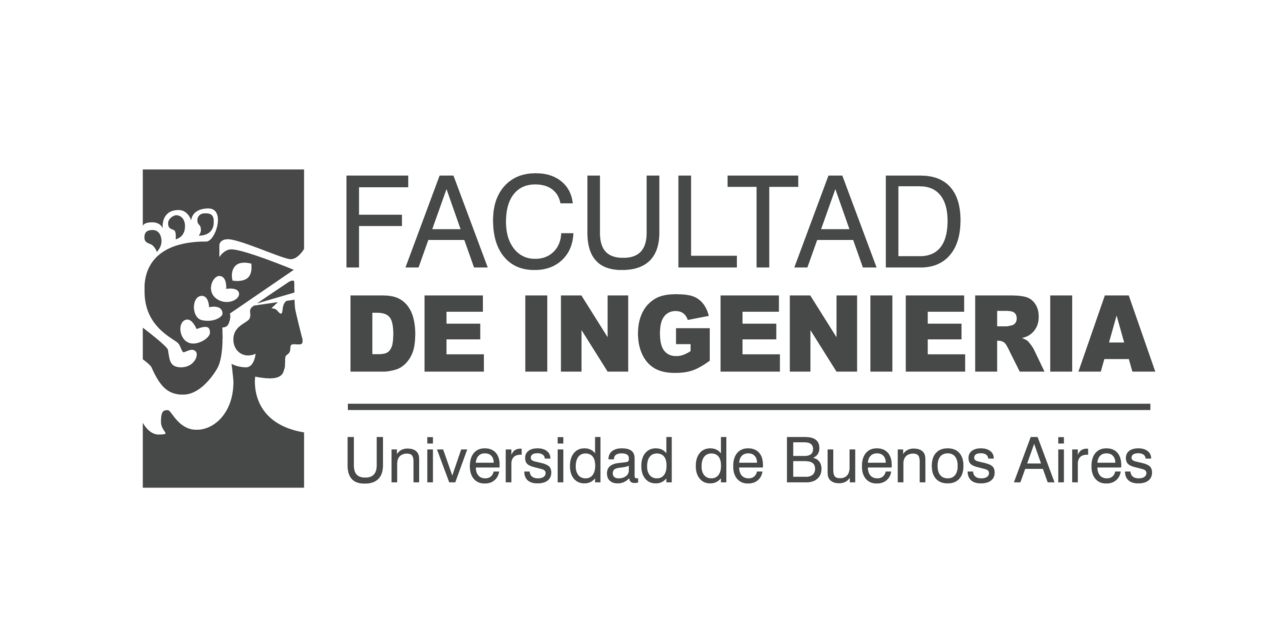

## Visión por Computadora 2 - TP Integrador
### Cohorte 18 - 2do bimestre 2025

**Profesores:** <br />
Ing. Juan Ignacio Cornet - juanignaciocornet@gmail.com <br />
Esp. Ing. Alfonso Rafel - alfonsorafel93@gmail.com <br />
Mg. Ing. Seyed Pakdaman - khodadad.pakdaman@gmail.com <br />

**Alumnos:** <br />
Mg. Ing. Joaquin Gonzalez - joagonzalez@gmail.com <br />
Ing. Pablo Martin Gomez Verdini - gomezpablo86@gmail.com <br />
Ing. Diego Paciotti Iacchelli - diegopaciotti@gmail.com <br />

**Repositorio Github**<br />
https://github.com/FIUBA-CEIA-18Co2024/VpC2-TP1 <br />

**Consigna**<br />
Ver [consigna](./doc/CONSIGNA.md)

## Prerequisitos y dependencias

In [2]:
%pip install gdown
%pip install pandas
%pip install numpy
%pip install torch
%pip install torchinfo
%pip install torchvision
%pip install seaborn
%pip install matplotlib
%pip install scikit-learn
%pip install kagglehub

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Imports de librerias utilizadas durnte el trabajo, definición de device (gpu o cpu) y definición de constantes que serán utilizadas en muchas ocasiones.

In [ ]:
import torch
import kagglehub
import torchvision
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from PIL import Image
import torchinfo as torchinfo
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from collections import defaultdict, Counter
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, WeightedRandomSampler, Subset
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix


# USAR GPU SI ES POSIBLE
device = "cuda" if torch.cuda.is_available() else "cpu"

# PARAMETROS GLOBALES
BATCH_SIZE = 64
WORKERS = 4
DATASET_AUGMENTED_SIZE = 4000

/home/jgonzalez/dev/.virtualenv/VpC2-TP1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Descarga y descompresión de dataset con imágenes.

In [4]:
path = kagglehub.dataset_download("mohamedhanyyy/chest-ctscan-images")
print("Path local al dataset recién descargado:", path)

Path local al dataset recién descargado: /home/jgonzalez/.cache/kagglehub/datasets/mohamedhanyyy/chest-ctscan-images/versions/1


## Utils

Funciones auxiliares que ayudan a resolver consignas del trabajo. Plotear, contadores, cálculos de media y varianza de canales de colores en imágenes, etc.

## 1. Preprocesamiento de Datos y EDA

### Analisis exploratorio

Completar

In [5]:
from src.eda import explore_dataset, plot_dataset_distribution

explore_dataset(path + '/Data')


Partición: train
Total de elementos: 613
  Clase 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 115 elementos
  Clase 'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 195 elementos
  Clase 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 155 elementos
  Clase 'normal': 148 elementos

Partición: test
Total de elementos: 315
  Clase 'normal': 54 elementos
  Clase 'adenocarcinoma': 120 elementos
  Clase 'large.cell.carcinoma': 51 elementos
  Clase 'squamous.cell.carcinoma': 90 elementos

Partición: valid
Total de elementos: 72
  Clase 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 21 elementos
  Clase 'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 23 elementos
  Clase 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 15 elementos
  Clase 'normal': 13 elementos


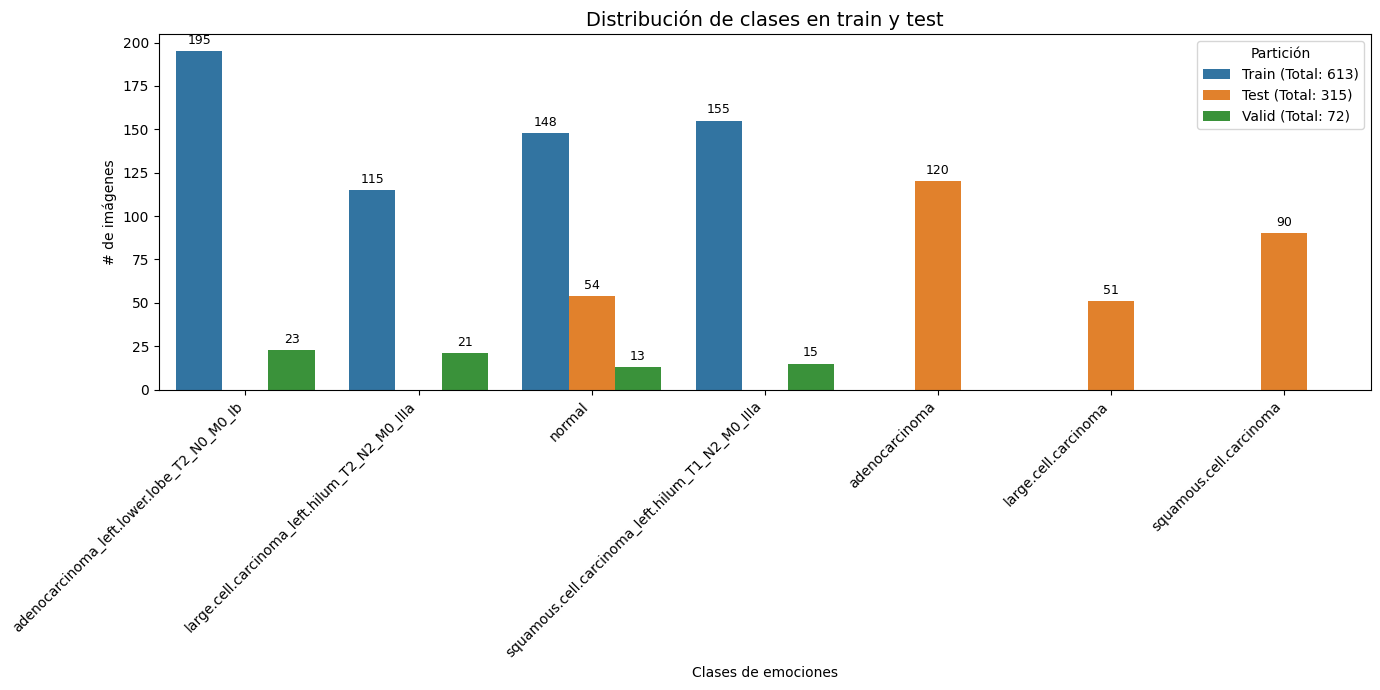

In [6]:
plot_dataset_distribution(path + '/Data')

Como se puede ver en el plot, las clases no estan normalizadas. Deberia haber 4 y ser las mismas a lo largo de las particiones train/test/validation. Se arregla esto generando un nuevo dataset con el mapeo siguiente.

In [7]:
from src.eda import reorganize_dataset

CLASS_MAP = {
    "adenocarcinoma": "adenocarcinoma",
    "adenocarcinoma_left.lower.lobe": "adenocarcinoma",
    "squamous.cell.carcinoma": "squamous_cell_carcinoma",
    "squamous.cell.carcinoma_left.hilum": "squamous_cell_carcinoma",
    "large.cell.carcinoma": "large_cell_carcinoma",
    "large.cell.carcinoma_left.hilum": "large_cell_carcinoma",
    "normal": "normal"
}

reorganize_dataset(
    source_path= path + '/Data',
    target_path="data/dataset",
    class_map=CLASS_MAP
)

Reorganizando dataset desde: /home/jgonzalez/.cache/kagglehub/datasets/mohamedhanyyy/chest-ctscan-images/versions/1/Data
Guardando en: data/dataset

train/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa → large_cell_carcinoma (115 imágenes)
train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib → adenocarcinoma (195 imágenes)
train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa → squamous_cell_carcinoma (155 imágenes)
train/normal → normal (148 imágenes)
test/normal → normal (54 imágenes)
test/adenocarcinoma → adenocarcinoma (120 imágenes)
test/large.cell.carcinoma → large_cell_carcinoma (51 imágenes)
test/squamous.cell.carcinoma → squamous_cell_carcinoma (90 imágenes)
valid/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa → large_cell_carcinoma (21 imágenes)
valid/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib → adenocarcinoma (23 imágenes)
valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa → squamous_cell_carcinoma (15 imágenes)
valid/normal → normal (13 imágenes)

Dataset reorganizado correc

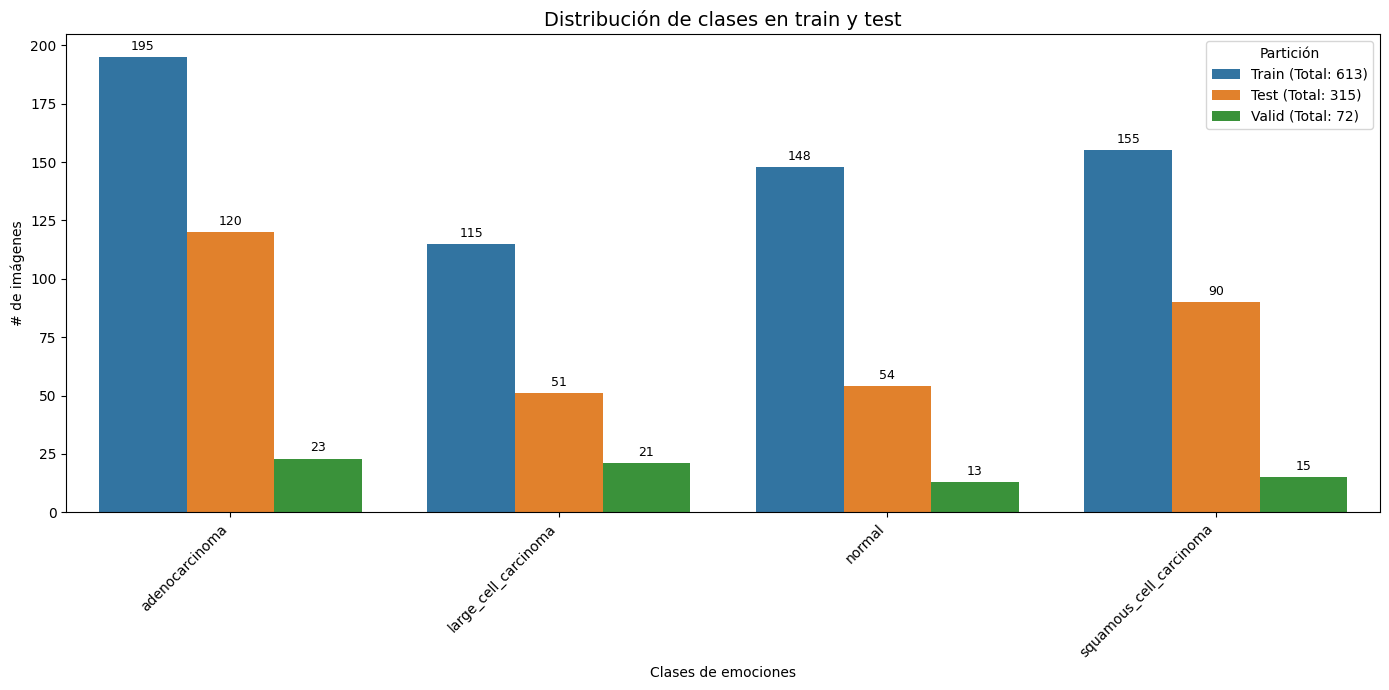

In [8]:
plot_dataset_distribution(dataset_path="data/dataset")

### Transformaciones DataLoaders

In [9]:
# 1- Se aplican distintas transformaciones para el dataset de train y test
train_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomResizedCrop(100, scale=(0.9, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

test_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

valid_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# 2- Se cargan los datasets de train y test con las transformaciones
train_dataset = datasets.ImageFolder(root='data/dataset' + '/train', transform=train_transform)
test_dataset = datasets.ImageFolder(root='data/dataset' + '/train', transform=test_transform)
valid_dataset = datasets.ImageFolder(root='data/dataset' + '/valid', transform=valid_transform)

# 3- Se splitea el dataset de train en train y validation para entrenamiento, test se deja para tarea final de evaluación
# Obtener las etiquetas de las imágenes en el dataset de entrenamiento
targets = [label for _, label in train_dataset]
class_counts = Counter(targets)
class_weights = {cls: len(targets) / count for cls, count in class_counts.items()}
sample_weights = torch.DoubleTensor([class_weights[label] for label in targets])

# 4 - Sampler balanceado
sampler = WeightedRandomSampler(weights=sample_weights,
                                num_samples=DATASET_AUGMENTED_SIZE,
                                replacement=True)

# 5 - DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=WORKERS, pin_memory=True)
val_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS, pin_memory=True)

# 6 - Info
print(f"Pesos por clase: {class_weights}")
print(f"Tamaño de train dataset original: {len(train_dataset)}")
print(f"Tamaño de train dataset con augmentation: {DATASET_AUGMENTED_SIZE}")
print(f"Tamaño de validation dataset: {len(valid_dataset)}")
print(f"Tamaño de test dataset: {len(test_dataset)}")

Pesos por clase: {0: 3.1435897435897435, 1: 5.3304347826086955, 2: 4.141891891891892, 3: 3.9548387096774196}
Tamaño de train dataset original: 613
Tamaño de train dataset con augmentation: 4000
Tamaño de validation dataset: 72
Tamaño de test dataset: 613


In [ ]:
from src.eda import map_counts_to_classnames, plot_class_distribution

# Tomamos una muestra del sampler para ver cómo quedó el balanceo
sampled_labels = []
for _, labels in train_loader:
    sampled_labels.extend(labels.numpy())
    if len(sampled_labels) >= DATASET_AUGMENTED_SIZE:
        break

# Conteo de clases en train y test
balanced_train_counts = Counter(sampled_labels)
test_counts = Counter(test_dataset.targets)
val_counts = Counter(valid_dataset.targets)

# Mapear IDs a nombres
train_counts_named = map_counts_to_classnames(balanced_train_counts, train_dataset.classes)
test_counts_named = map_counts_to_classnames(test_counts, test_dataset.classes)
val_counts_named = map_counts_to_classnames(val_counts, valid_dataset.classes)

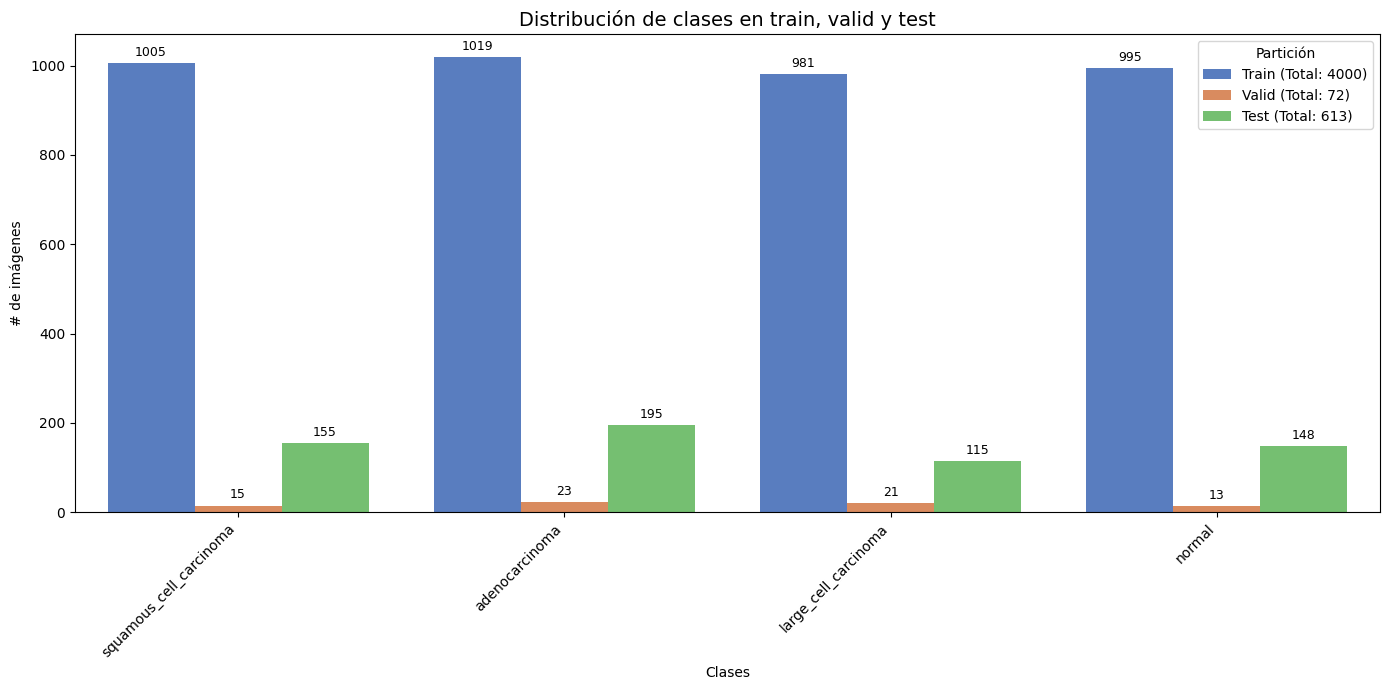

In [11]:
plot_class_distribution({
    "Train": train_counts_named,
    "Valid": val_counts_named,
    "Test": test_counts_named
})

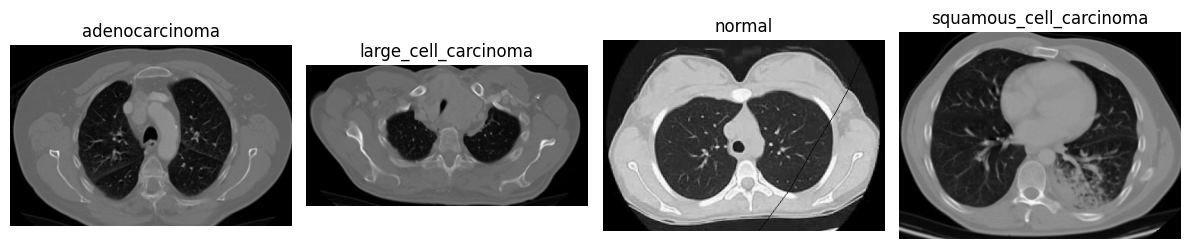

In [12]:
from src.eda import show_first_image_per_class_no_transform

# Mostrar primera imagen por clase sin transformaciones del dataset original
show_first_image_per_class_no_transform(train_dataset)

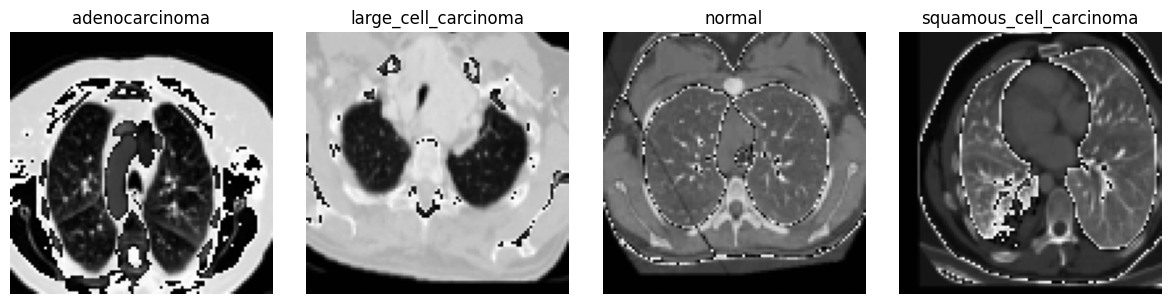

In [15]:
from src.eda import show_first_image_per_class

# Mostrar primera imagen por clase con transformaciones del dataset original
show_first_image_per_class(train_dataset, train_dataset.classes)

## 2. Construcción y entrenamiento del Modelo CNN

En esta sección se presentan dos arquitecturas de redes neuronales convolucionales (CNN) desarrolladas de manera iterativa. Para mejorar la claridad y facilitar la comparación, se agrupan sus definiciones y resultados en un único lugar.

#### Early Stopping

Implementaremos **Early Stopping** para optimizar el tiempo de entrenamiento y evitar sobreajuste. Este mecanismo detiene el entrenamiento cuando no se observa una mejora significativa en la función de pérdida del conjunto de validación durante un número consecutivo de épocas, definido por el parámetro *patience*.

**Funcionamiento:**
1. **Patience**: Es el número de épocas consecutivas sin mejora aceptable en la pérdida antes de detener el entrenamiento.
2. **min_delta**: Define la mejora mínima requerida en la pérdida para considerar que el modelo está progresando. Si la pérdida de validación no mejora al menos en `min_delta` respecto a la mejor pérdida registrada, se incrementa el contador de paciencia.
3. **Detención**: Si el contador de paciencia alcanza el valor de *patience*, el entrenamiento se detiene automáticamente.

De esta manera nos aseguramos que el modelo no siga entrenándose innecesariamente cuando ya no está mejorando.

#### Función de entrenamiento

La función de entrenamiento se integra con la clase **Early Stopping** para detener el proceso de entrenamiento cuando no se observan mejoras significativas en la pérdida del conjunto de validación durante un número consecutivo de épocas.

**Mejoras implementadas:**
1. **Guardado del mejor modelo**:
    - Se agrega el parámetro `model_name` para guardar los pesos del modelo con el mejor desempeño en validación. Esto permite cargar el modelo posteriormente para evaluación o inferencia.

2. **Persistencia de resultados**:
    - Se introduce el parámetro `results_file` para guardar las métricas de entrenamiento y validación (pérdida, accuracy y F1 score) en un archivo JSON. Esto facilita el análisis y la visualización de los resultados sin necesidad de reentrenar.

3. **Cálculo de F1 Score**:
    - Se incluye el cálculo del **F1 score weighted**, una métrica más robusta que considera el desbalance de clases.

4. **Regularización con Weight Decay**:
    - Se agrega soporte para **weight decay** en el optimizador mediante un parámetro booleano (`weight_decay`). WD penaliza los pesos grandes en el modelo, ayudando a reducir el sobreajuste. Se utiliza en la última variante del modelo entrenado.

#### Entrenamiento

Desacoplamos los plots de entrenamiento para poder cambiar la estetica sin reentrenar. Además, persistimos esa información en un JSON file y tambien guardamos el mejor modelo (entre todas las epocas) para utilizar luego evitando el overfitting si Early Stopping tuviese un parámetro de paciencia alto.

In [ ]:
# Entrenamos CNN 1
fit(cnn_simple, train_loader=train_loader, eval_loader=val_loader, epochs=30, model_name='data/cnn_1_weights.pth', results_file='data/cnn_1_train_results.json')   

In [ ]:
plot_train_results_from_json(json_file='cnn_simple_train_data.json')

In [ ]:
# Entrenamos CNN 2
fit(model=model, train_loader=train_loader, eval_loader=val_loader, epochs=80, model_name='data/cnn_2_weights.pth', results_file='data/cnn_2_train_results.json')

In [ ]:
plot_train_results_from_json(json_file='cnn_train_data.json')

## 3. Evaluación de Modelos

Completar

### Evaluación

In [ ]:
# Se carga el modelo final
model = CNNFinal()
# Se carga el modelo final desde el archivo que se generó durante el entrenamiento
model.load_state_dict(torch.load('data/ccn_1_weights.pth', map_location=device))
model.eval()  # Configurar el modelo en modo evaluación
print("Modelo cargado correctamente.")

`evaluate_model` evalúa el rendimiento de un modelo entrenado en un dataset de test y genera métricas para analizar su desempeño.

#### **Parámetros**
- **`model`**: Modelo entrenado que se evaluará.
- **`data_loader`**: DataLoader que contiene el conjunto de datos de prueba.
- **`class_names`**: Lista con los nombres de las clases del problema.
- **`device`**: Dispositivo en el que se ejecutará la evaluación (`'cpu'` o `'cuda'`).
- **`output_file`**: Nombre del archivo JSON donde se guardarán los resultados de la evaluación.

#### **Lógica**
1. **Modo evaluación**: Configura el modelo en modo evaluación (`model.eval()`) para desactivar el cálculo de gradientes.
2. **Inferencia**:
    - Recorre el DataLoader y realiza predicciones para cada batch.
    - Almacena las predicciones y etiquetas para calcular métricas.
3. **Cálculo de métricas**:
    - **Matriz de confusión**: Se genera tanto en valores absolutos como normalizados.
    - **Reporte de clasificación**: Incluye precisión, recall y F1-score por clase.
4. **Visualización**:
    - Se generan gráficos de las matrices de confusión (absoluta y normalizada).
5. **Resultados**:
    - Los resultados se guardan en un archivo JSON para análisis posterior.

#### **Salida de la función**
- Imprime las métricas calculadas.
- Genera gráficos de las matrices de confusión.
- Guarda los resultados en un archivo JSON que pueden ser utilizados luego para análisis y comparación.

In [ ]:
plot_train_results_from_json(json_file='data/cnn_1_train_results.json')

In [ ]:
evaluate_model(model, test_loader, test_dataset.classes, device, output_file='data/cnn_1_evaluation_results.json')

`generate_classification_report` evalúa el modelo entrenado en dataset y genera métricas de evaluación.

#### **Parámetros**
- **`model`**: Modelo entrenado que se evaluará.
- **`data_loader`**: DataLoader que contiene el conjunto de datos de prueba.
- **`class_names`**: Lista con los nombres de las clases del problema.
- **`device`**: Dispositivo en el que se ejecutará la evaluación (`'cpu'` o `'cuda'`). Este parámetro esta definido al comienzo del trabajo.

#### **Lógica**
1. **Modo evaluación**: Configura el modelo en modo evaluación (`model.eval()`) para desactivar el cálculo de gradientes.
2. **Inferencia**:
    - Recorre el DataLoader y realiza predicciones para cada batch.
    - Calcula la pérdida acumulada utilizando la función de pérdida `CrossEntropyLoss`.
    - Almacena predicciones y etiquetas para calcular métricas.
3. **Cálculo de métricas**:
    - **Accuracy**
    - **F1 Score (weighted)**
    - **Reporte de clasificación**
    - **Pérdida promedio**

#### **Salida de la función**
- Imprime el reporte de clasificación, accuracy, F1 score y pérdida promedio.
- Devuelve un diccionario con las métricas calculadas.


In [ ]:
results = generate_classification_report(model, test_loader, test_dataset.classes, device)

## 4. Transfer Learning

Completar

## 5. Conclusiones

Completar